In [7]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
import random
import matplotlib.pyplot as plt


In [22]:
# Replace 'your_file.pkl' with the path to your pickle file
# file_path = "Connect4Dataset_RandomOpp_Firstmove.pkl"
file_path = "Connect4Dataset_SmartRandom_hrishi.pkl"

# Open the pickle file in read mode
with open(file_path, "rb") as file:
    dataset_progressive_skill = pickle.load(file)

In [141]:
# Should only have plus moves. For minus, multiply the board by -1. Save -1(board) for the minus turn.
# Think about this, might not need to have this, but possibly some iteration of this

# EDA

### Viewing a single game

In [12]:
def view_game(dataset, game_number):
    """
    View all moves, skill levels, and associated information for a single game.

    Parameters:
        dataset (list): The dataset containing board states and moves.
        game_number (int): The game number to view (1-based index).

    Returns:
        None
    """
    print(f"Game {game_number}:")

    # Filter dataset for the specified game
    game_moves = [record for record in dataset if record[0] == game_number]

    for move_number, record in enumerate(game_moves, start=1):
        game_id, board, move, player1_skill, player2_skill, player = record

        # Display the details of the current move
        print(f"Move number {move_number}:")
        print("Board State Before Move:")
        print("Plus Player Layer:")
        print(board[:, :, 0])  # Player 1's layer
        print("Minus Player Layer:")
        print(board[:, :, 1])  # Player 2's layer
        print(
            f"Move position: {move}, Player: {player}, Plus Player Skill: {player1_skill}, Minus Player Skill: {player2_skill}"
        )
        print("-" * 50)


view_game(dataset_progressive_skill, game_number=1)  # View the first game

Game 1:
Move number 1:
Board State Before Move:
Plus Player Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Minus Player Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Move position: 3, Player: plus, Plus Player Skill: 2205, Minus Player Skill: 2376
--------------------------------------------------
Move number 2:
Board State Before Move:
Plus Player Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
Minus Player Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Move position: 1, Player: minus, Plus Player Skill: 2205, Minus Player Skill: 2376
--------------------------------------------------
Move number 3:
Board State Before Move:
Plus Player Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0

### Convert to pandas df

In [23]:
# Convert the dataset to a DataFrame, including board state
data = []
for record in dataset_progressive_skill:
    game_id, board, move, player1_skill, player2_skill, player = record
    data.append(
        {
            "Game ID": game_id,
            "Board State": board,
            "Move": move,
            "Player 1 Skill": player1_skill,
            "Player 2 Skill": player2_skill,
            "Player": player,
        }
    )

connect4 = pd.DataFrame(data)

# COMBINED DATA

In [61]:
connect4 = pd.read_pickle("Connect4Dataset_SmartRandom_combined.pkl")

In [62]:
connect4.shape

(523242, 6)

In [63]:
connect4.head(10)

# np.flip
# 6 - best_move

,Game ID,Board State,Move,Player 1 Skill,Player 2 Skill,Player
0,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,plus
1,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,minus
2,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,plus
3,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,minus
4,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,plus
5,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,minus
6,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,plus
7,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,minus
8,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,plus
9,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",0,1748,2477,minus


##### Look at a board state from pandas df

In [51]:
# Access the board state for the first record
# board_state = connect4.loc[1, "Board State"]
print("Player 1 Layer:")
print(connect4.loc[2, "Board State"][:, :, 0])  # Player 1's layer
print("Player 2 Layer:")
print(connect4.loc[2, "Board State"][:, :, 1])  # Player 2's layer

Player 1 Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
Player 2 Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]


## Make the board states from player 1s perspective only

In [64]:
# def standardize_board_state(df):
#     """
#     Converts all board states to be from Player 1's perspective.
#     If Player 2 made the move, the board is flipped and the move adjusted.

#     Args:
#         df (pd.DataFrame): Original DataFrame with "Board State", "Move", and "Player".

#     Returns:
#         pd.DataFrame: New DataFrame where all moves are from the same player perspective.
#     """
#     standardized_data = []

#     for _, row in df.iterrows():
#         game_id = row["Game ID"]
#         p1 = row["Player 1 Skill"]
#         p2 = row["Player 2 Skill"]
#         board = row["Board State"]
#         move = row["Move"]
#         player = row["Player"]

#         # If Player 2 made the move, flip the board horizontally and adjust move
#         if player == "minus":
#             board = np.flip(board, axis=1)  # Flip horizontally
#             # move = 6 - move  # Only need to adjust when flipping board

#         # Extract only Player 1's board (first slice of the 6x7x2 array)
#         board_layer = board[:, :, 0]

#         # Store the transformed data
#         standardized_data.append(
#             {
#                 "Game ID": game_id,
#                 "Board State": board_layer,
#                 "Move": move,
#                 "Player 1 Skill": p1,
#                 "Player 2 Skill": p2,
#             }
#         )

#     return pd.DataFrame(standardized_data)


def standardize_board_state(board, player):
    """
    Swap [0,1] to [1,0] and [1,0] to [0,1] in a given board only if player == -1.
    """

    # if isinstance(player, str):
    #     player = int(player)

    if player == "minus":
        board = np.array(board)  # Ensure it's a NumPy array

        # Create masks
        mask_01 = (board[:, :, 0] == 0) & (board[:, :, 1] == 1)  # Find [0,1]
        mask_10 = (board[:, :, 0] == 1) & (board[:, :, 1] == 0)  # Find [1,0]

        # Swap values
        board[mask_01] = [1, 0]
        board[mask_10] = [0, 1]

    return board  # Return the modified or original board

In [65]:
# Apply to each board where the player is -1
connect4_standardized = connect4.copy()
connect4_standardized["Board State"] = connect4_standardized.apply(
    lambda row: standardize_board_state(row["Board State"], row["Player"]), axis=1
)

In [66]:
connect4_standardized.shape

(523242, 6)

In [55]:
connect4_standardized.head(10)

,Game ID,Board State,Move,Player 1 Skill,Player 2 Skill,Player
0,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,plus
1,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,minus
2,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,plus
3,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,minus
4,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,plus
5,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,minus
6,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,plus
7,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2,1748,2477,minus
8,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3,1748,2477,plus
9,0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",0,1748,2477,minus


In [151]:
# Access the board state for the first record
# board_state = connect4.loc[1, "Board State"]
print("Player 1 Layer:")
print(connect4_standardized.loc[1, "Board State"][:, :, 1])  # Player 1's layer
print("Player 2 Layer:")
print(connect4_standardized.loc[2, "Board State"][:, :, 1])  # Player 2's layer

Player 1 Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
Player 2 Layer:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]]


### Add flipped board states

In [67]:
def flip_board(board):
    """Flip the board horizontally."""
    return np.flip(board, axis=1)


def add_flipped_boards(df):
    """
    Add flipped boards to the dataset, updating the Game ID for flipped boards.
    Args:
        df: A Pandas DataFrame with columns "Game ID", "Board State", "Move",
             "Player 1 Skill", "Player 2 Skill", and "Player".
    Returns:
        A new DataFrame with original and flipped boards, where flipped boards have updated Game IDs.
    """
    flipped_rows = []
    max_game_id = df[
        "Game ID"
    ].max()  # Start new Game IDs after the max ID in the original DataFrame

    for game_id, group in df.groupby("Game ID"):  # Group by each game
        for _, row in group.iterrows():
            # Extract board state, move, and other columns
            board = row["Board State"]
            move = row["Move"]
            other_columns = row.drop(
                ["Game ID", "Board State", "Move"]
            ).to_dict()  # Extract other columns

            # Add the original board state
            flipped_rows.append(
                {
                    "Game ID": game_id,  # Keep the original Game ID
                    "Board State": board,
                    "Move": move,
                    **other_columns,
                }
            )

            # Flip the board and adjust the move
            flipped_board = flip_board(board)
            flipped_move = 6 - move  # Adjust move for flipped board

            # Add the flipped board state with a new Game ID
            flipped_rows.append(
                {
                    "Game ID": max_game_id
                    + 1,  # Increment Game ID for flipped board states
                    "Board State": flipped_board,
                    "Move": flipped_move,
                    **other_columns,
                }
            )

        # Increment the max_game_id for the next game
        max_game_id += 1

    # Create a new DataFrame from the rows
    return pd.DataFrame(flipped_rows)

In [68]:
# Apply the function to your DataFrame
connect4_wflip = add_flipped_boards(connect4_standardized)
connect4_wflip.shape

(1046484, 6)

### Unqiue dataset ...?

In [75]:
# Create a hashable representation of each board state
# Flatten the 3D board state and convert it into a tuple
hashed_board_states = connect4["Board State"].apply(lambda x: tuple(x.ravel()))
hashed_board_states_2 = connect4_wflip["Board State"].apply(lambda x: tuple(x.ravel()))

# Find the number of unique hashed board states
unique_board_states_count = len(hashed_board_states.unique())
unique_board_states_count_2 = len(hashed_board_states_2.unique())

print(f"Number of unique board states before flip: {unique_board_states_count}")
print(f"Number of unique board states after flip: {unique_board_states_count_2}")

Number of unique board states before flip: 197915
Number of unique board states after flip: 165695


### Drop duplicates

In [76]:
# Create a hashable representation of each board state
connect4["hashed_board"] = connect4["Board State"].apply(lambda x: tuple(x.ravel()))
connect4_wflip["hashed_board"] = connect4_wflip["Board State"].apply(
    lambda x: tuple(x.ravel())
)

# Drop duplicate board states
unique_connect4 = connect4.drop_duplicates(subset=["hashed_board"]).drop(
    columns=["hashed_board"]
)
unique_connect4_wflip = connect4_wflip.drop_duplicates(subset=["hashed_board"]).drop(
    columns=["hashed_board"]
)

# Display the number of unique board states
print(f"Unique board states (before flip): {len(unique_connect4)}")
print(f"Unique board states (after flip): {len(unique_connect4_wflip)}")
print(f"Unique games (after flip): {len(unique_connect4_wflip['Game ID'].unique())}")

Unique board states (before flip): 197915
Unique board states (after flip): 165695
Unique games (after flip): 17796


### Move frequencies

In [29]:
# Plot the frequency of recommended moves
unique_connect4["Move"].value_counts().sort_index().plot(kind="bar", figsize=(10, 5))
plt.title("Distribution of Recommended Moves before flipping")
plt.xlabel("Move (Column Index)")
plt.ylabel("Frequency")
plt.show()


# Plot the frequency of recommended moves
unique_connect4_wflip["Move"].value_counts().sort_index().plot(
    kind="bar", figsize=(10, 5)
)
plt.title("Distribution of Recommended Moves after flipping")
plt.xlabel("Move (Column Index)")
plt.ylabel("Frequency")
plt.show()


# Should be same

NameError: name 'unique_connect4' is not defined

Recommended Move Distribution for Empty Board States:
Move
0     163
1     171
2     227
3    4884
4     224
5     166
6     165
Name: count, dtype: int64


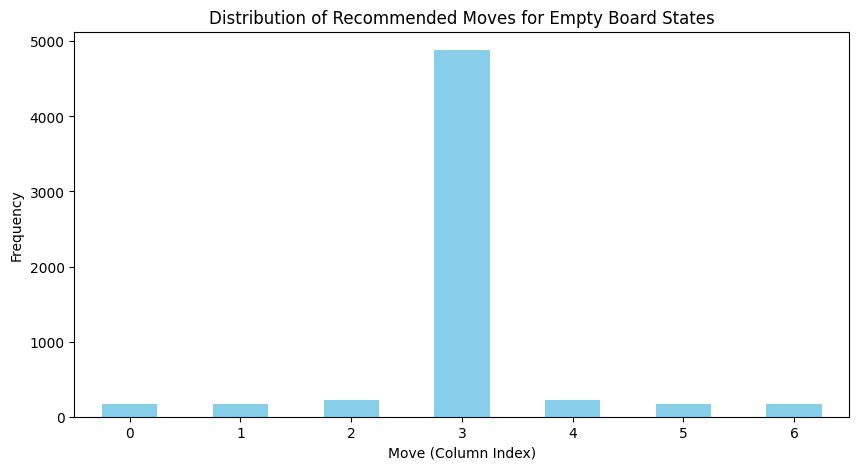

In [30]:
# Identify rows where the board state is empty
# An empty board state means all elements in both layers are zero
empty_board_states = connect4["Board State"].apply(lambda x: np.all(x == 0))

# Filter the dataset to only include these rows
empty_boards_df = connect4[empty_board_states]

# Check the distribution of recommended moves
move_distribution = empty_boards_df["Move"].value_counts().sort_index()

# Print the distribution
print("Recommended Move Distribution for Empty Board States:")
print(move_distribution)

# Visualize the distribution
move_distribution.plot(kind="bar", figsize=(10, 5), color="skyblue")
plt.title("Distribution of Recommended Moves for Empty Board States")
plt.xlabel("Move (Column Index)")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

# CNN Testing

In [73]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Flatten,
    Dense,
    Dropout,
    MaxPooling2D,
    SpatialDropout2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

### Subset games for intial testing

In [59]:
# def subset_games(df, num_games):
#     """
#     Subset a DataFrame based on a random sample of unique game IDs.

#     Parameters:
#         df (pd.DataFrame): The input DataFrame with a 'game id' column.
#         num_games (int): The number of unique game IDs to subset.

#     Returns:
#         pd.DataFrame: A subset of the original DataFrame.
#     """
#     # Get the unique game IDs
#     unique_game_ids = df["Game ID"].unique()

#     # Ensure the requested number of games doesn't exceed the available unique IDs
#     if num_games > len(unique_game_ids):
#         raise ValueError(
#             f"num_games ({num_games}) exceeds the total unique game IDs ({len(unique_game_ids)})."
#         )

#     # Randomly sample the desired number of unique game IDs
#     sampled_game_ids = pd.Series(unique_game_ids).sample(num_games, random_state=42)

#     # Subset the DataFrame
#     subset_df = df[df["Game ID"].isin(sampled_game_ids)]

#     return subset_df

In [ ]:
# num_games = 12000  # Specify the number of games to include
# connect4_testing = subset_games(connect4_wflip, num_games)

# # Print some details
# print(f"Subset contains {len(connect4_testing)} board states from {num_games} games.")

Subset contains 1046484 board states from 12000 games.


In [70]:
connect4_testing = connect4_wflip.copy()

### Split data for train/val

In [71]:
# Extract features (board states) and labels (recommended moves)
X = np.stack(
    connect4_testing["Board State"].values
)  # Convert board states into a NumPy array
y = connect4_testing["Move"].values

# Normalize the board states (optional for CNNs)
X = X.astype("float32") / 1.0  # Assuming board states are binary (0 or 1)

# Convert labels to one-hot encoding (required for multi-class classification)
num_classes = 7  # Moves are in columns 0-6
y = to_categorical(y, num_classes)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(
    f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}"
)

Training set: (732538, 6, 7, 2), Validation set: (156973, 6, 7, 2), Test set: (156973, 6, 7, 2)


### New board from P1 perspective

In [74]:
num_classes = 7  # 7 output classes (which column to drop in)

# Define Improved CNN (~4.5M parameters)
model = Sequential(
    [
        # **Initial Convolutional Block**
        Conv2D(32, (3, 3), activation="relu", input_shape=(6, 7, 2), padding="same"),
        BatchNormalization(),
        SpatialDropout2D(0.2),
        # **Convolutional Block 1**
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 1)),  # Reduce height, keep full width
        Dropout(0.3),
        # **Convolutional Block 2**
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        Conv2D(
            128, (3, 3), activation="relu", strides=(2, 2), padding="same"
        ),  # Strided conv instead of pooling
        Dropout(0.3),
        # **Convolutional Block 3**
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 1)),  # Reduce height, keep width
        Dropout(0.4),
        # **Convolutional Block 4**
        # Conv2D(512, (3, 3), activation="relu", padding="same"),
        # BatchNormalization(),
        # Conv2D(512, (3, 3), activation="relu", padding="same"),
        # Conv2D(
        #     512, (3, 3), activation="relu", strides=(1, 2), padding="same"
        # ),  # Reduce width slightly
        # Dropout(0.4),
        # **Fully Connected Layers**
        Flatten(),
        Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        # **Output Layer**
        Dense(num_classes, activation="softmax"),
    ]
)


# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Print Model Summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 6, 7, 32)       │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 6, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 6, 7, 32)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 6, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 6, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 3, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 3, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 3, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 2, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 2, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 2, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,970,151 (7.52 MB)

 Trainable params: 1,969,191 (7.51 MB)

 Non-trainable params: 960 (3.75 KB)

### Train

In [ ]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_accuracy",  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights from the best epoch
    verbose=1,
)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],  # Add early stopping to callbacks
    verbose=1,
)

Epoch 1/10
11446/11446 ━━━━━━━━━━━━━━━━━━━━ 309s 27ms/step - accuracy: 0.3991 - loss: 1.8044 - val_accuracy: 0.5736 - val_loss: 1.2140 - learning_rate: 0.0010
Epoch 2/10
11446/11446 ━━━━━━━━━━━━━━━━━━━━ 316s 28ms/step - accuracy: 0.5557 - loss: 1.2886 - val_accuracy: 0.6050 - val_loss: 1.1188 - learning_rate: 0.0010
Epoch 3/10
 4145/11446 ━━━━━━━━━━━━━━━━━━━━ 3:07 26ms/step - accuracy: 0.5827 - loss: 1.2134

In [39]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1686/1686 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6493 - loss: 1.0049
Test Loss: 1.0092, Test Accuracy: 0.6480


In [40]:
# Path for model
new_path = "best_model_combined.h5"

model.save(new_path)

In [ ]:
# Try Resnet code. Skip connections, normalization, relu before the normalization

### Post train analysis 

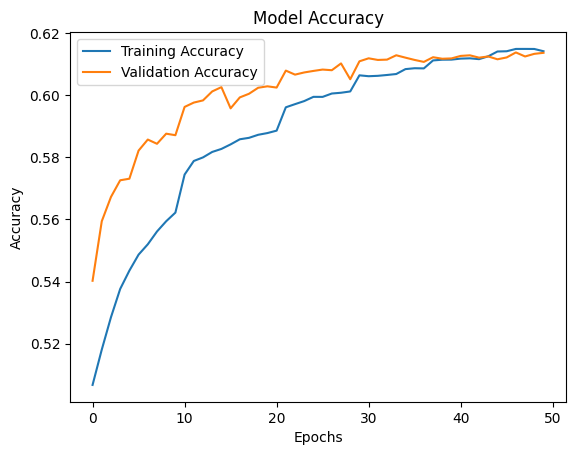

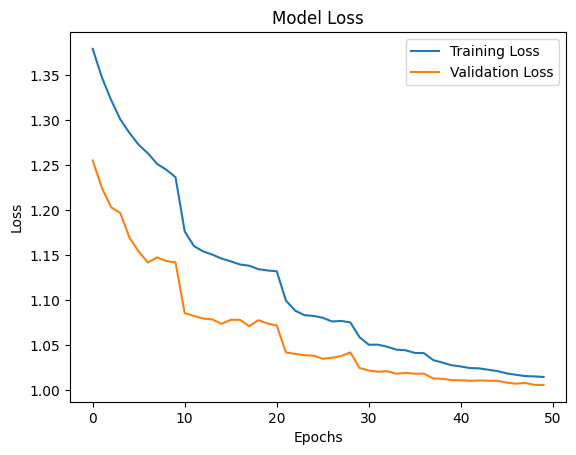

In [24]:
# Visualize performance

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Look at some predicitons

In [88]:
# Predict on a few test samples
predictions = model.predict(X_test[:5])
predicted_moves = np.argmax(predictions, axis=1)
true_moves = np.argmax(y_test[:5], axis=1)

# Display predictions vs true labels
for i in range(5):
    print(f"Board State {i+1}:")
    print("Player 1 Layer:")
    print(X_test[i][:, :, 0])  # Player 1's layer
    print("Player 2 Layer:")
    print(X_test[i][:, :, 1])  # Player 2's layer
    print(f"True Move: {true_moves[i]}, Predicted Move: {predicted_moves[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Board State 1:
Player 1 Layer:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1.]]
Player 2 Layer:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]]
True Move: 0, Predicted Move: 3
--------------------------------------------------
Board State 2:
Player 1 Layer:
[[1. 0. 1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0.]]
Player 2 Layer:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 1.]]
True Move: 4, Predicted Move: 4
--------------------------------------------------
Board State 3:
Player 1 Layer:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.